 # Mise en place des modèles statistiques

In [1]:
!pip install sktime;
!pip install --upgrade nbformat;


[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from music21 import converter, instrument, note, chord, stream
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd
import os
import seaborn as sns
from tqdm import tqdm
import numpy as np
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
!unzip dataset.zip

unzip:  cannot find or open dataset.zip, dataset.zip.zip or dataset.zip.ZIP.


## Useful Functions

In [154]:
def get_notes(midi):
  notes = []

  notes_from_midi = midi.flatten().notesAndRests
  notes_sorted = sorted(notes_from_midi, key=lambda note: note.offset)

  prev_start = notes_sorted[0].offset

  for element in notes_sorted:
    if isinstance(element , note.Note):
      notes.append((float(element.offset), float(element.volume.velocity),float(element.seconds), str(element.pitch), float(element.offset-prev_start)))
    elif isinstance(element, chord.Chord):
      #notes.append((float(element.offset), float(element.volume.velocity), float(element.seconds), '+'.join(str(n) for n in element.normalOrder)))
      for noteChord in element.pitches:
        notes.append((float(element.offset),float(element.volume.velocity), float(element.seconds), str(noteChord), float(element.offset-prev_start)))

    elif isinstance(element, note.Rest):
        # Bizarre car main gauche et droite flatten (réunie)
        # Voir autre implémentation
        pass
        #notes.append((float(element.offset), 0,float(element.seconds), "REST", float(element.offset-prev_start)))

    prev_start = element.offset
  return notes

def check_pitch(x):
  if ('+' in x) or x.isdigit():
        notes_in_chord = x.split('+')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord =chord.Chord(notes).pitches[0].midi
        return new_chord
    # pattern is a note
  elif 'REST' in x:
    return 0
  else:
        new_note = note.Note(x).pitch.midi
        return new_note
  
def plot_ys(*series, labels=None):
  nb_series=len(series)
  colors = ['blue', 'red', 'green']
  fig = []
  data = None
  for i in range(nb_series):
    fig.append(px.line(series[i]))
    if labels is not None:
      fig[i].update_traces(name= labels[i])
    fig[i].update_traces(line_color=colors[i])
    if data==None:
      data = fig[i].data
    else:
      data = data + fig[i].data
  figFinal = go.Figure(data = data)
  return figFinal


## Extracting song informations'

In [5]:
note_all_songs = []
for folder in tqdm(os.walk("dataset")):
    if len(folder) != 3:
      continue
    else:
      for file in folder[2]:
        file_path = str(folder[0])+"/"+file

        # convertit la piste midi
        midi = converter.parse(file_path)

        # récupère les notes, volume, dureées...
        notes = get_notes(midi)

        # ajoute à une liste globale
        note_all_songs.append(notes)

0it [00:00, ?it/s]

3it [01:30, 30.16s/it]


In [131]:
# fais un dataframe à partir de toutes les notes (sans distinctions)
df = pd.DataFrame([], columns=['offset','volume','duration', 'note_str', 'step'])
df = df.reset_index(drop=True)
for elem in note_all_songs:
    df2 = pd.DataFrame(elem, columns=['offset','volume','duration', 'note_str', 'step'])
    df2 = df2.reset_index(drop=True)
    df =pd.concat([df,df2])
    df = df.reset_index(drop=True)
df['note_int'] = df['note_str'].apply(check_pitch)

In [132]:
df

,offset,volume,duration,note_str,step,note_int
0,0.0,49.0,0.115794,E-4,0.0,63
1,0.0,49.0,0.115794,B3,0.0,59
2,0.0,49.0,0.115794,E4,0.0,64
3,0.0,48.0,0.115794,G#3,0.0,56
4,0.0,48.0,0.115794,E-3,0.0,51
...,...,...,...,...,...,...
146829,804.0,80.0,0.230326,E4,0.5,64
146830,804.0,60.0,0.230326,A1,0.0,33
146831,804.0,60.0,0.230326,E2,0.0,40
146832,804.0,60.0,0.230326,A2,0.0,45


## Analyse exploratoire

In [133]:
print("Il y a : ",df.shape[0]," notes dans le dataset")

Il y a :  146834  notes dans le dataset


In [134]:
nb_unique_notes = len(df['note_str'].unique())
print("Il y a :",str(nb_unique_notes),"notes uniques.")

Il y a : 78 notes uniques.


### Notes

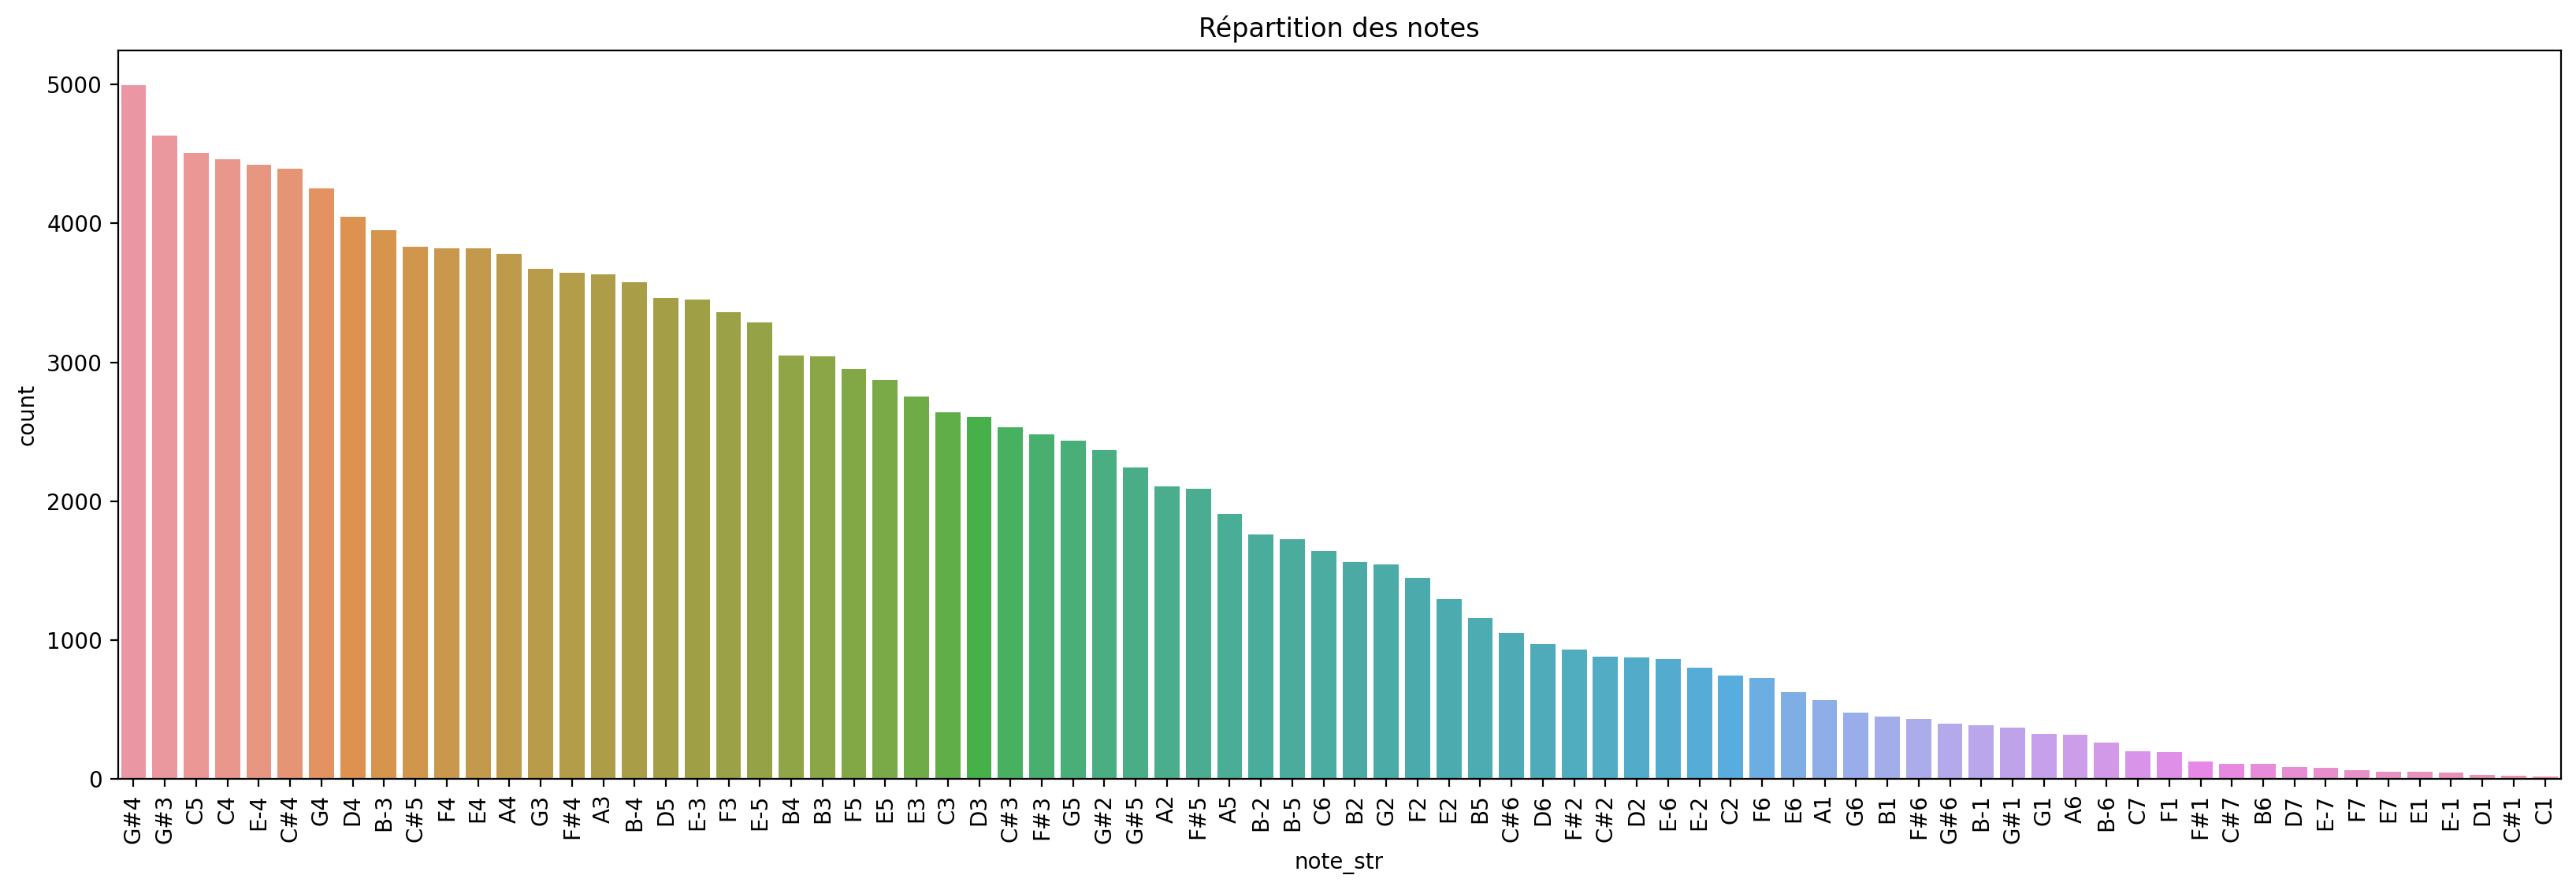

In [136]:
order = df["note_str"].value_counts().index

plt.figure(figsize=(20, 6))  # Ajustez la largeur (12) selon vos besoins

sns.countplot(df, x="note_str", order=order);
plt.xticks(rotation=90);
plt.title("Répartition des notes");


La répartition des notes est loin d'être équitable, les notes en 'G' et 'C' sont bien plus utilisées que celles en 'D' et 'B'. Ici, il y a beaucoup de classes différentes, même s'il y a une classe dominantes, elle ne domine pas de beaucoup par rapport à la suivante.
Ce déséquilibre pourra potentiellement impactée les prédictions selon la manière dont on les utilisent.

### Durée des notes

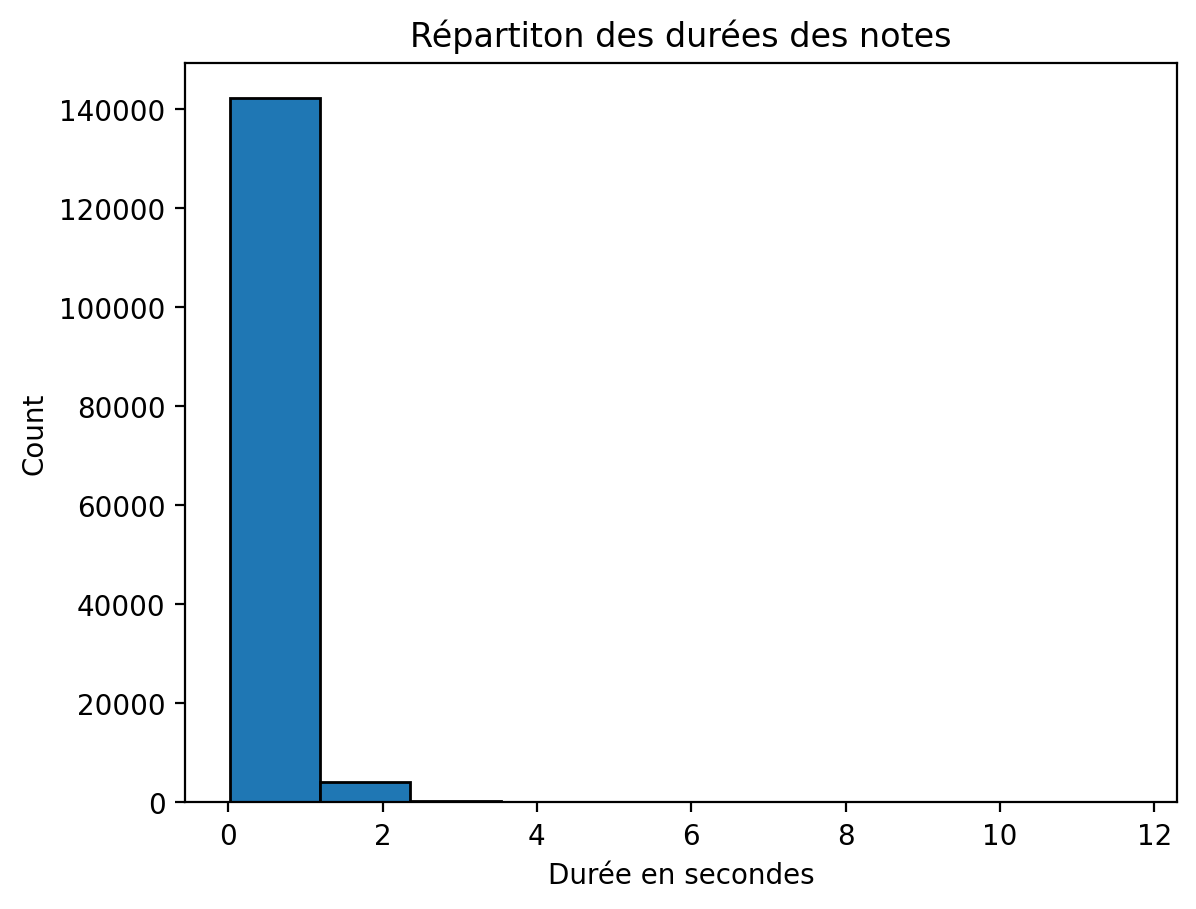

In [139]:
plt.hist(df['duration'], edgecolor='k', bins=10);
plt.title("Répartiton des durées des notes");
plt.xlabel("Durée en secondes");
plt.ylabel("Count");

In [15]:
df['duration'].agg(['mean', max, min])

mean     0.311333
max     11.707317
min      0.024213
Name: duration, dtype: float64

La durée des notes (en s), et elle aussi loin d'être également répartie. En utilisant 10 bins, on voit qu'il y a une classe largement majoritaire, si dans les notes entre la première et la deuxième l'écart était faible, ici la classe dominante majoritairement. La plus grande majorité des notes  durent moins de 1.2 secondes envirions, et le reste de 20% est répartis entre 1.2s et 11.7s. La prédiction de cette variable va être très problématique par la suite, elle ne sera qu'utilisée qu'avec les réseaux de neurones.

Comme le montre les statistiques, la moyenne est de 0.31s, alors que le minimum est à 0.024s et le max à 11.7s. Pour démontrer ce déséquilibre, un diagramme en boite peut suffire.

<Axes: >

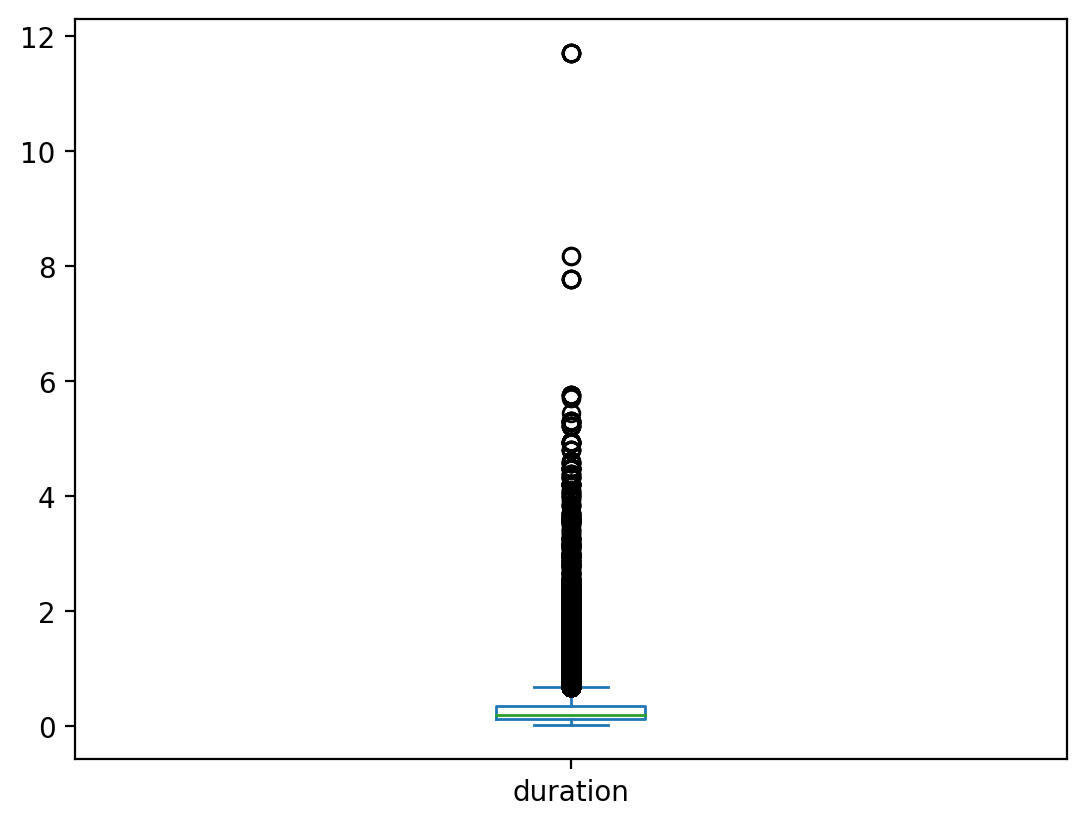

In [16]:
df['duration'].plot(kind='box')

### Durée entre chaque notes

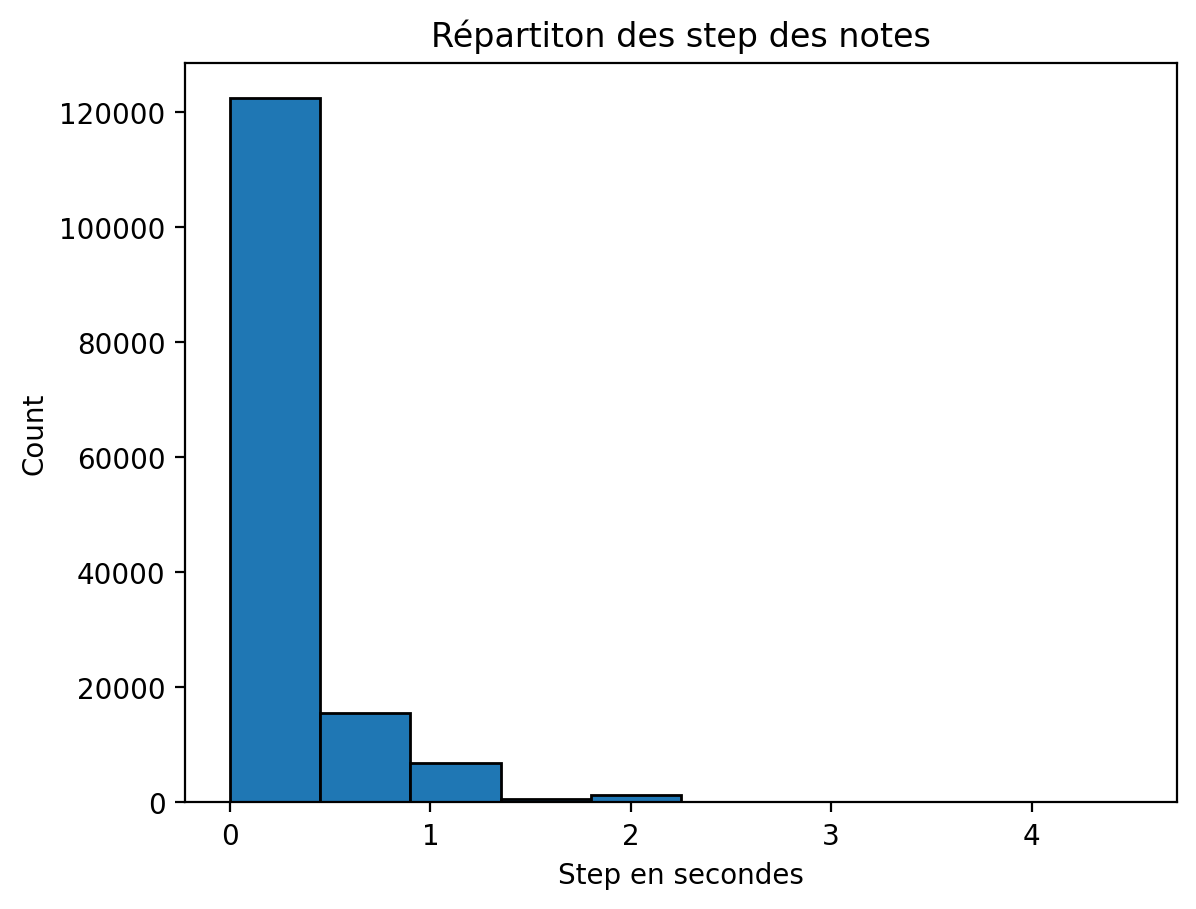

In [140]:
plt.hist(df['step'], edgecolor='k', bins=10);
plt.title("Répartiton des step des notes");
plt.xlabel("Step en secondes");
plt.ylabel("Count");

In [18]:
df['step'].agg(['mean', max, min])

mean    0.252251
max     4.500000
min     0.000000
Name: step, dtype: float64

La durée entre chaque notes (step), et toute aussi déséquilirée que la répartition de la durée des notes, même si un peu plus équilibrée. La très grande majorité a un espacement entre 0 et 0.5s, la classe suivante bien plus faible en densité est répartie entre 0.5s et 4.5s. Si

Comme les statistiques le montrent, la durée entre chaque notes est d'en moyenne de 0.25s, avec un minimum de 0s (touche simultanées) et 4.5s. Encore une fois, le déséquilibre est assez important, ce qui rendra la prédiction de cette classe assez compliquée, bien heuresement cette variable ne sera utilisée qu'avec les réseaux de neurones. Un diagramme en boite permet de constater ce déséquilibre.

<Axes: >

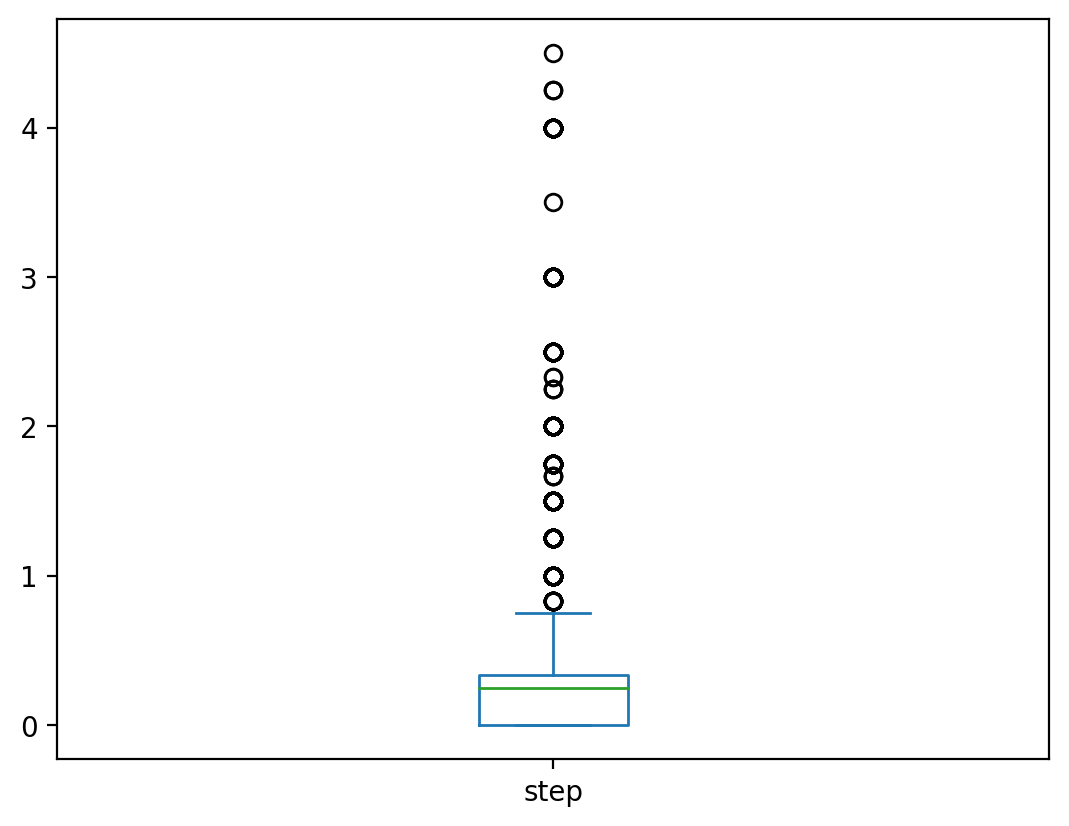

In [19]:
df['step'].plot(kind='box')

### Le volume

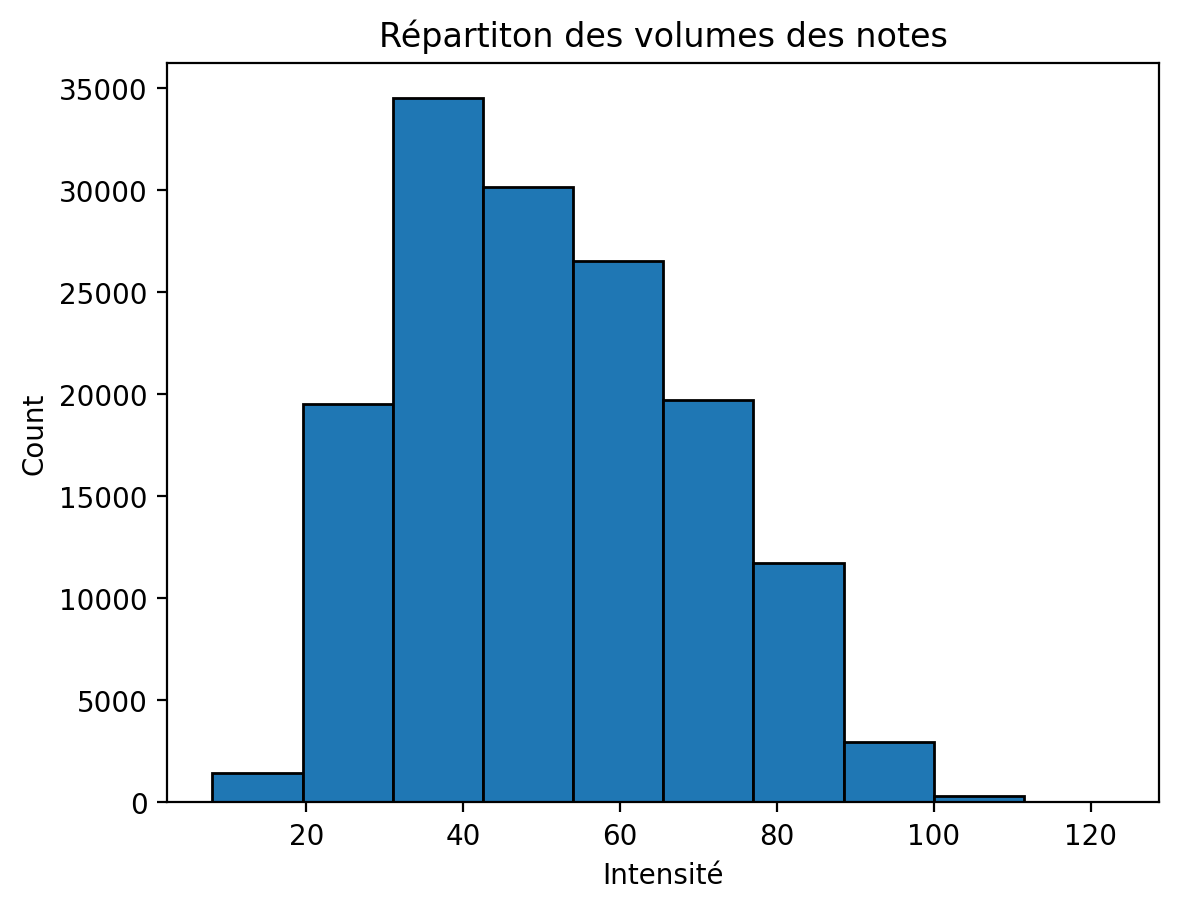

In [141]:
plt.hist(df['volume'], edgecolor='k', bins=10);
plt.title("Répartiton des volumes des notes");
plt.xlabel("Intensité");
plt.ylabel("Count");

In [21]:
df['volume'].agg(['mean', max, min])

mean     50.919494
max     123.000000
min       8.000000
Name: volume, dtype: float64

Pour finir, la dernière variable relative aux notes que l'on peut étudier est le volume. C'est sûrement la variable la moins utile, puisqu'elle ne renseigne aucun éléments à l'harmonie auditive contrairement à la note ou au step, elle sert juste à améliorer la répartition du son et l'accentuation de certaine note. La particularité de cette variable est d'être un entier borné entre 0 et 127 (imposé par midi21). En voyant l'histogramme, elle semble suivre une loi normale, c'est la variable la mieux répartie.

Ce caractère est explicable, puisque la plupart du temps, le compositeur jouera des notes de volume moyen, c'est à seulement certains moments qu'il voudra ajouter de la variation (volume faible ou élevé). Avec comme valeur minimum 8, moyenne 50.91 et max 123 sa répartition est tout aussi équitable.

<Axes: >

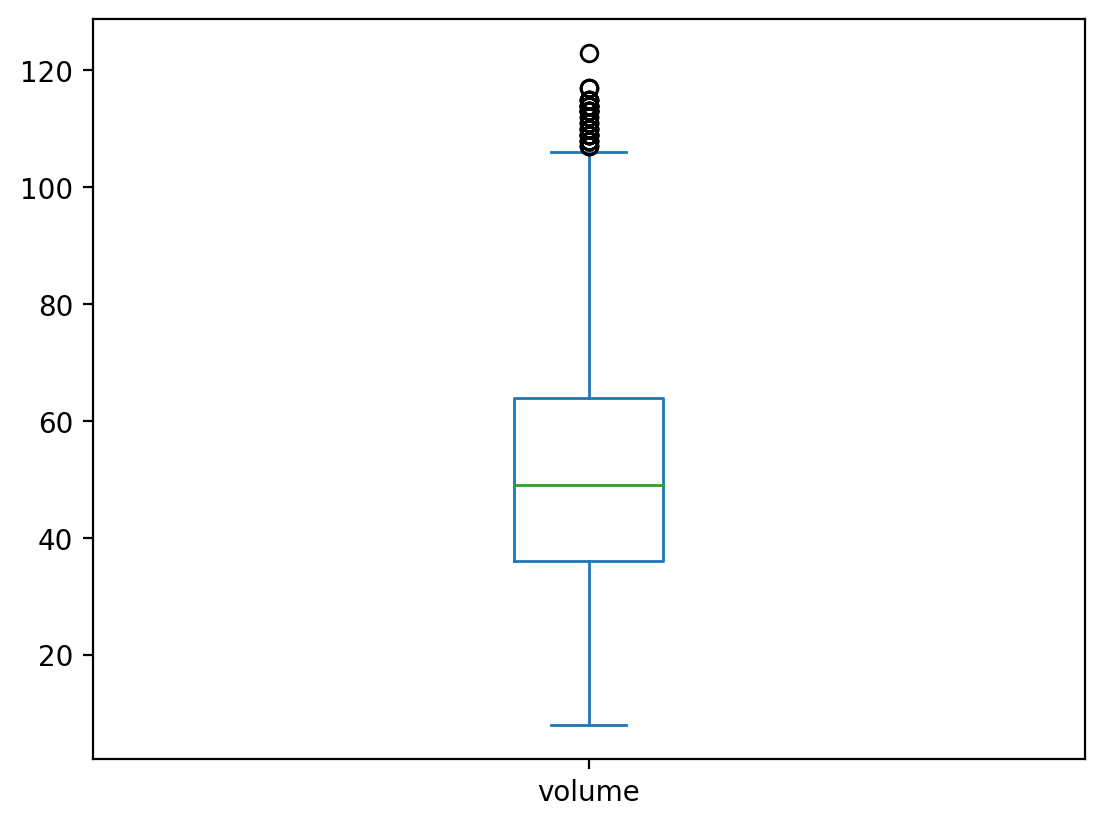

In [22]:
df['volume'].plot(kind='box')

## Préparation des données

Comme la librairie 'sktime' permettant d'implémenter la prédiction de série temporelle ne permet l'utilisation que d'une seule série temporelle, nous n'allons prendre qu'un unique morceau.

Pourquoi un seul morceau ?
Lors de l'utilisation de 'sktime', quand on souhaite entraîner un modèle sur des séries temporelles on ne lui fournit une array de valeur (supposée ordonnée chronologiquement car temporelle), ce qui ne peut pas être fait avec plusieurs morceaux. Si on décide de tous les concaténer ou même de les mettre à la suite, le passage d'un morceau à un autre donnera une information fausse. Pourtant, dans ce cas là, cette information fausse sera minoritaire puisque il n'y en aura que 49 (si on concatène les 50 morceaux), malheuresement il y a aussi l'implémentation de 'sktime' puisque la méthode 'predict' ou 'forecast' se font sur les données d'entraînement et pas sur un unique morceau. 
Donc cela reste tout de même faisable si on gère bien les choses, mais par soucis d'efficacité et du détails on n'utilisera qu'un unique morceau pour les prédictions statistiques, et l'entièreté du dataset pour les réseaux de neurones.

**Sonata No. 17 Bb major, KV 570 (1789) Allegro**

In [41]:
midi_statistical_pred = converter.parse("statistical_data/mz_570_1.mid");
notes_statistical_pred = get_notes(midi_statistical_pred)

C:\Users\gabriel\AppData\Roaming\Python\Python311\site-packages\music21\midi\translate.py:874: TranslateWarning:

Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=5, channel=None, data=b'Copyright \xa9 2006 by Bernd Krueger'>; getting generic Instrument



In [142]:
df_music = pd.DataFrame(notes_statistical_pred, columns=['offset','volume','duration', 'note_str', 'step'])
df_music['note_int'] = df_music["note_str"].apply(check_pitch)

note_standardized = StandardScaler().fit(df_music[['note_int']])
df_music['note_std'] = note_standardized.transform(df_music[['note_int']])

Afin de pouvoir effectuer les futures prédictions et les faciliter, on transforme les notes en entier selon leur rang. Il faut maintenant voir les notes comme des classes auxquelles on a donné comme label un entier qui lui est associé. De cette manière on pourra les prédire est les afficher.
De plus, comme les notes peuvent aller de 0 à 88 (car 88 touches de piano), on décide de normaliser les données pour faciliter les prédiction étant donné que la plage de valeur est assez grande.

In [143]:
fig = px.line(df_music['note_int'])
fig.update_layout(
    title="Mozart Sonata No. 17 Bb major, KV 570 (1789) Allegro",
    xaxis_title="Nombre de notes",
    yaxis_title="Pitch de la note"
)

In [144]:
fig = px.line(df_music['note_std'])
fig.update_layout(
    title="Mozart Sonata No. 17 Bb major, KV 570 (1789) Allegro",
    xaxis_title="Nombre de notes",
    yaxis_title="Pitch de la note (standardisée)"
)

Même si on trace des entiers, cela représente quand même les notes de piano. Malgré l'aspect chaotique du graphique, on peut quand même y déceler un ordre et une certaine régularité avec des motifs qui se répètent.

### Décomposition STL

En temps normal, une série temporelle aurait un caractère récurrent avec certaine fois une période ou une saisonnalité. Ici le termes de période et saisonnalité n'ont pas de sens pour une musique, cela a beau être une série temporelle avec des entiers ces termes ne lui sont pas appliquables. Ainsi, pour tenter une décomposition STL pour la mention de périod, comme ici il n'est pas question de semaine, de jours ou de mois, on peut essayer de repérer un caractère se répétant et voir combien de fois il se répète, ce qui formerait donc une période.

In [145]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
result = STL(df_music['note_int'], period = 6).fit()

In [146]:
fig = px.line(result.observed)
fig.update_layout(
    title="Mozart Sonata No. 17 [...] - Résultat observé",
    xaxis_title="Nombre de notes",
    yaxis_title="Pitch de la note (standardisée)"
)

In [147]:
fig = px.line(result.trend)
fig.update_layout(
    title="Mozart Sonata No. 17 [...] - Tendance",
    xaxis_title="Nombre de notes",
    yaxis_title="Pitch de la note (standardisée)"
)

In [148]:
fig = px.line(result.seasonal)

fig.update_layout(
    title="Mozart Sonata No. 17 [...] - Saisonnalité",
    xaxis_title="Nombre de notes",
    yaxis_title="Pitch de la note (standardisée)"
)

La décomposition en tendance et saisonnalité pourrait sembler cohérente, du moins les graphique purrait être correctes. On voit clairement la période qui semble être la mélodie principale avec des mouvements répétées comme des refrains.

### Données d'entraînement et de test

Comme pour toute prédiction, il faut des données d'entraînement et de test, ici on est sur un morceau donc les données seront les notes sous forme d'entiers. Pour simplifer les choses et accélérer les calculs on va prendre les données standardisées. Les données des test seront les 25 dernière notes du morceau.

In [234]:
y = df_music['note_int']
y_train, y_test = temporal_train_test_split(y, test_size=25)

In [235]:
y_test

4125    53
4126    57
4127    74
4128    75
4129    72
4130    70
4131    46
4132    50
4133    53
4134    58
4135    65
4136    67
4137    65
4138    63
4139    45
4140    41
4141    62
4142    63
4143    60
4144    58
4145    46
4146    74
4147    77
4148    82
4149    34
Name: note_int, dtype: int64

In [236]:
fig = plot_ys(y_train, y_test, labels=["y_train", "y_test"])
fig.show();


In [237]:
fh = np.arange(1,len(y_test)+1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25])

L'horizon sera de 25, on cherchera à comparer les 25 prochaines notes à partir des données d'entraînement et les 25 prochaines notes réelles.

## Mise en place des méthode statistiques

Maintenant que les données sont prêtes, et qu'on a une idée plus générale des données, de leur sens et de leur contexte on peut commencer la mise en place de méthode statistique (le réseau de neurones c'est après). On a nos données d'entraînement et de tests, tout est donc prêt.

### Approches naïves

On commence par utiliser une approche naïve, c'est à dire un modèlequi ne réfléchit pas (presque pas). Dans le cas présent, le modèle appliqera la stratégie "last" avec sp=8, c'est à dire que la note à l'instant 't' sera la même qu'à l'instant 't-8'.

In [239]:
from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last", sp=6)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec NaiveForecaster (sp=6)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")


La loss est de 0.27325989528714917 %.


La prédiction naïve est comme on pourrait le penser : bête et méchante. La loss est d'environ 0.27%, ce qui est plutôt faible, la prédiction est en totale décalage avec les notes réelles. Mais cela constitue déjà une prédiction initiale et une base de comparaison pour les futurs modèle de prédiction.

### KNeighbors

On va maintenant appliqué une méthode non naïve : celle des KNeighbors. Le but derrière est de prédire la note suivante en fonction de l'entourage de la fenêtre, ces voisins sont censés donnés une information sur la note prochaine. On s'attend à avoir des résultats meilleurs que ceux de la méthode naïves.

In [240]:
#from sktime.forecasting.compose import ReducedForecaster as ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction


regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(estimator=regressor,
                                         window_length=10, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec KNeighborsRegressor(n=3)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.20232914163901883 %.


In [241]:
regressor = KNeighborsRegressor(n_neighbors=25)
forecaster = make_reduction(estimator=regressor,
                                         window_length=10, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec KNeighborsRegressor(n=25)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.24855884306412981 %.


Sans rechercher dans le détails et en modifiant assez rapidement les paramètres, on peut s'apercevoir que les résultats sont tout de suite meilleur qu'avec la méthode naïve. Ici la loss est d'envrion 0.14%, ce qui est moins que la loss de la méthode naïve, une telle avancée avec un tel modèle montre que la musique peut suivre un certain schéma qui se répète.

#### Fine tuning des KNeighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)

In [ ]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

In [ ]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [ ]:
gscv.best_params_
gscv.best_forecaster_

### RandomForest

On essaye maintenant une autre méthode statistique, celle de la random forest. En effectuant la réduction, le modèle classique de forêt aléatoire sera adaptée à la prédiction temporelle, puisque ici il faut garder un ordre. Une fois de plus, avec un tel modèle on s'attend à avoir des meilleurs résultats que dans le cas précédent.

In [242]:
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor(n_estimators=200)
forecaster = make_reduction(estimator=regressor, window_length=15,
                                         strategy="recursive")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec RandomForest(n=200)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.1888621725985023 %.


In [243]:
regressor = RandomForestRegressor(n_estimators=500)
forecaster = make_reduction(estimator=regressor, window_length=15,
                                         strategy="recursive")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec RandomForest(n=500)"
)
fig.show();
loss_perc = smape_loss(y_pred, y_test)
print("La loss est de", loss_perc,"%.")

La loss est de 0.14651259038116168 %.


La loss est un peu plus basse que celle des KNeighbors (0.18 < 0.20).
Cela démontre que la forêt aléatoire est en capacité d'appréhender des relations plus complexes entre les notes, sur la prédiction, on peut voir que sl es notes prédites suivent à peu de choses près la tendances des notes originales.

#### Fine tuning

In [96]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200]}#, 200, 300]}
forecaster_param_grid = {"window_length": [5,  10]}#,15,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)
# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=forecaster_param_grid
)

In [98]:
cv

SlidingWindowSplitter(initial_window=160, window_length=20)

In [97]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

KeyboardInterrupt: ignored

In [ ]:
print(gscv.best_params_)
print(gscv.best_forecaster_.estimator.estimator.get_params())

### Exponential Smoothing

On va maintenant appliquer le lissage exponentielle avec différente librairie ayant une implémentation différente. Pour ces modèle on ne s'attend pas à avoir des résultats plus performants, puisque la musique a un caractère non linéaire et très changenant comme le montrait les graphiques, ce qui n'est pas forcément le type de données adaptées au lissage exponentielle.

#### Sktime

In [244]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive",
                                  sp=6)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec Exponential Smoothing (sp=6)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.24585017847117593 %.


Le lissage exponentielle dans sa prédiction n'a que très peu de variation et d'amplitude, ce qui est contraire à la musique et aux notes réelles. La loss est quant à elle plus élevée que pour la random forest, même si assez faible (0.24%) les notes prédites sont en total décalage.

#### Statsmodels

In [245]:
import statsmodels as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

fit1 = ExponentialSmoothing(y_train, seasonal_periods=6,
                            trend='add', seasonal='add', use_boxcox=False,
                            initialization_method="estimated").fit()
y_pred = fit1.forecast(25)
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec Exponential Smoothing (statsmodels)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.24585017847117593 %.


Le résultat est très simialire au lissage expoentielle de sktime.

#### ETSModel

In [246]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
model = ETSModel(y_train.astype('float64'), error="add", trend="add", seasonal="add",
                damped_trend=True, seasonal_periods=6)
fit = model.fit()
y_pred = fit.forecast(25)

In [247]:
simulated = fit.simulate(anchor="end", nsimulations=36, repetitions=100)

In [248]:
fig = plot_ys(y_train[-200:], y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
fig.update_layout(
    title="Prédiction avec Exponential Smoothing (ETSModel)"
)
fig.show();
loss_perc = smape_loss(y_test, y_pred)
print("La loss est de", loss_perc,"%.")

La loss est de 0.24617565242630793 %.


Encore une fois, cela ne change pas. Le lissage exponentielle, même implémentée dans une librairie différente a toujours ausis peu d'amplitude dans ses prédictions, ce qui est contraire à ce qui devrait être.

In [213]:
px.line(simulated)

c:\Python311\Lib\site-packages\plotly\express\_core.py:1223: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



Quant aux simulations, elles changent toutes énormément.

### ARIMA

Comme autre modèle statistique, on se propose d'essayer un modèle ARIMA. Pour utiliser un tel modèle, il est nécessaire de retirer les saisonnalités de la série temporelle. A partir de maintenant on s'aventure sur un terrain glissant, étant donné que le terme de saisonnalité n'a que très peu de sens pour une  musique, on va donc quand même essayer. Mais on ne s'attend pas à avoir de meilleurs résultats que dans les cas précédents.

#### Traitement des données

<Axes: >

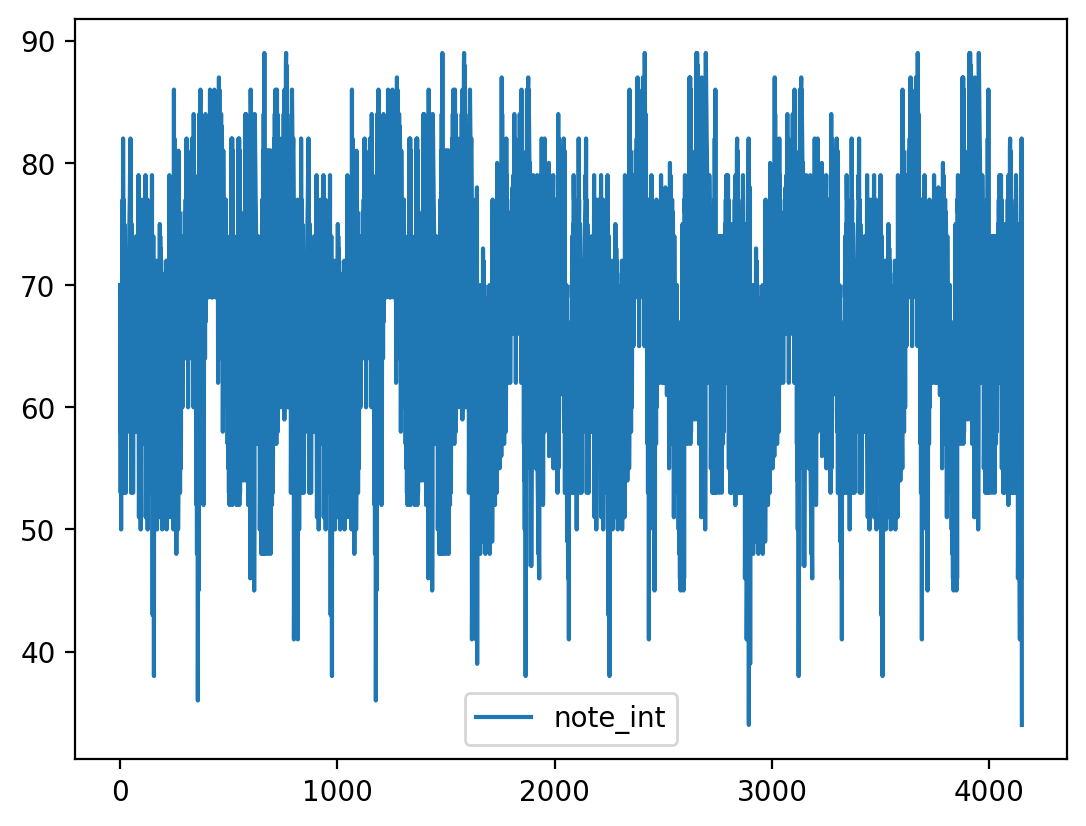

In [249]:
from scipy.stats import boxcox
data = df_music['note_int']
a = data
pd.DataFrame(a).plot()

In [250]:
from statsmodels.tsa.seasonal import STL, seasonal_decompose
out = seasonal_decompose(a, period=6)

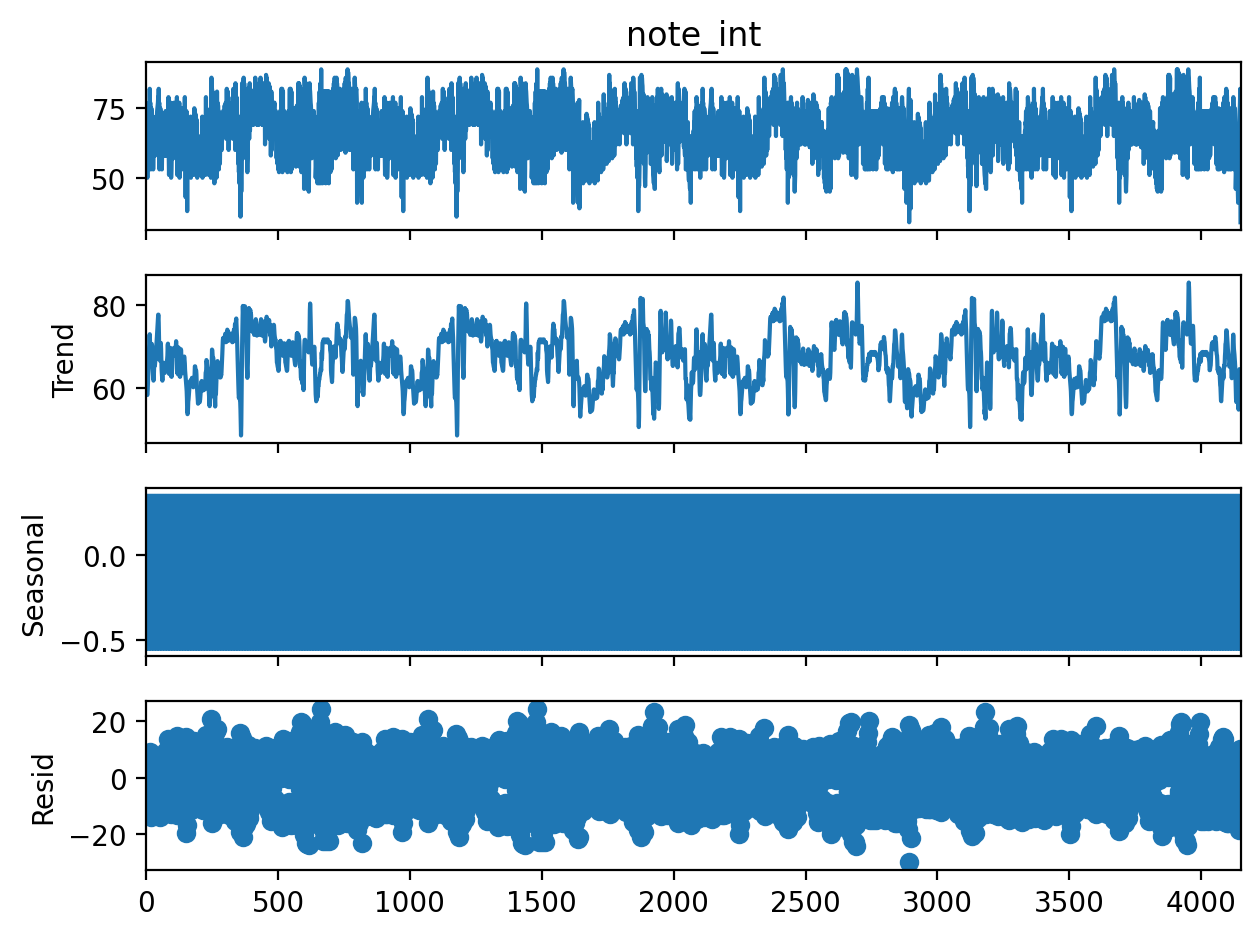

In [251]:
out.plot();

<Axes: >

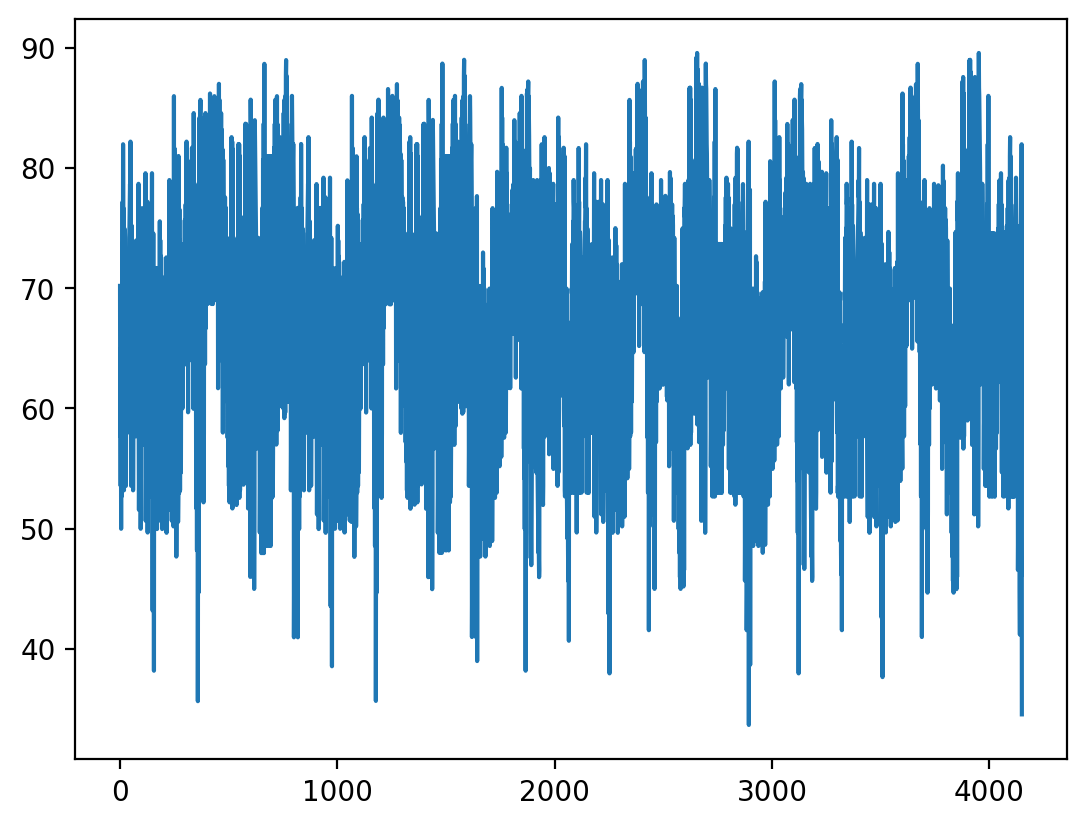

In [252]:
x =  out.observed - out.seasonal
x.plot()

#### Calcul des ordres

In [253]:
from statsmodels.tsa.stattools import adfuller, kpss
adf, pa, *_  = adfuller(x.dropna())
print("p-value adf : ", pa)

p-value adf :  5.8447347873704114e-09


La p-value est déjà faible mais pas assez on va donc la diff une fois, on peut donc ensuite passer à l'étape pour trouver les ordres pour le modèle ARIMA.

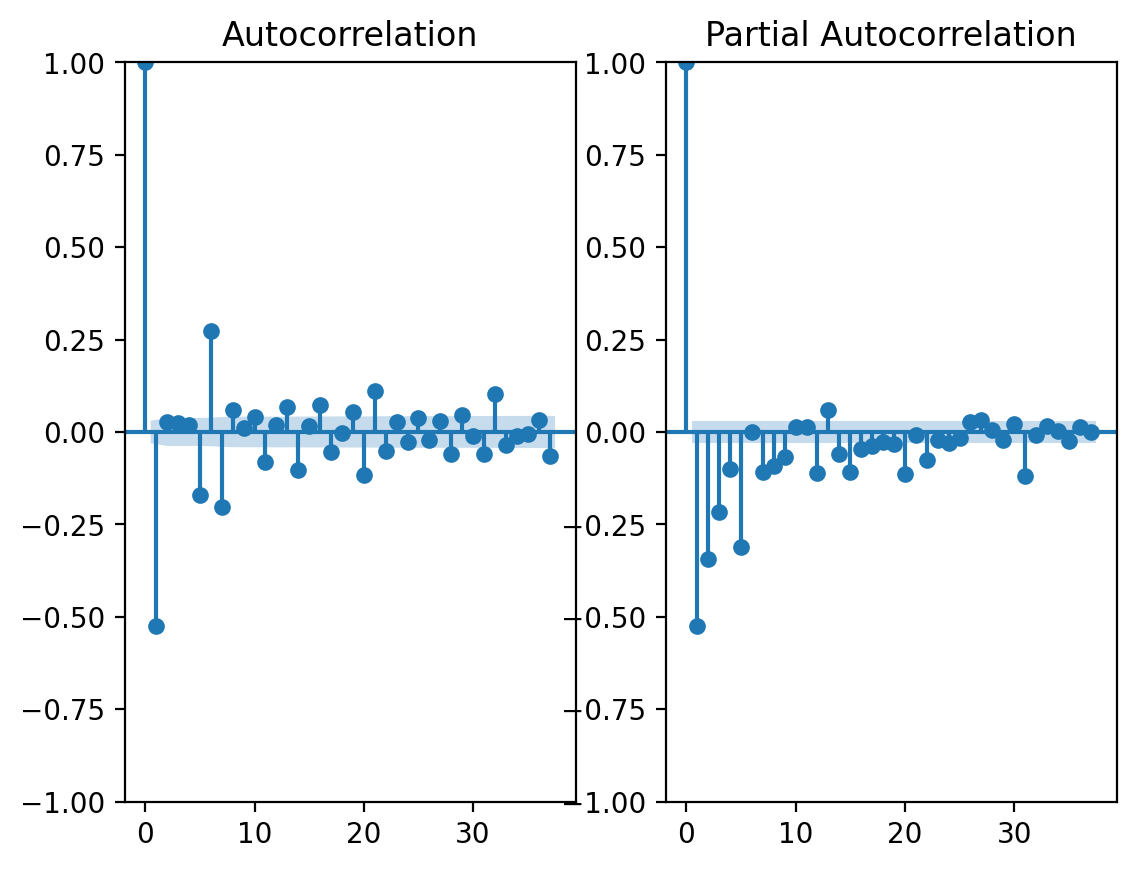

In [254]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df = data.diff()
fig, ax = plt.subplots(1,2)
plot_acf(df.dropna(), ax=ax[0])
plot_pacf(df.dropna(), ax=ax[1]);

En regardant les graphiques d'auto corrélation et auto corrélation partielle, c'est assez étrange. On continue quand même, en comptant les points on déterminer que nous aurons un ARIMA(5,1,0)

In [255]:
from statsmodels.tsa.arima.model import ARIMA
mod = ARIMA(x, order=(5,1,0))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4150
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -15034.813
Date:                Tue, 07 Nov 2023   AIC                          30081.626
Time:                        11:22:49   BIC                          30119.610
Sample:                             0   HQIC                         30095.065
                               - 4150                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8403      0.013    -65.851      0.000      -0.865      -0.815
ar.L2         -0.6478      0.015    -42.615      0.000      -0.678      -0.618
ar.L3         -0.4749      0.017    -28.158      0.000      -0.508      -0.442
ar.L4         -0.3568      0.016    -22.356      0.000      -0.388      -0.325
ar.L5         -0.3141      0.013    -23.810      0.000      -0.340      -0.288
sigma2        82.2361      1.687     48.752      0.000      78.930      85.542
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.14
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.09
Prob(H) (two-sided):                  0.64   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

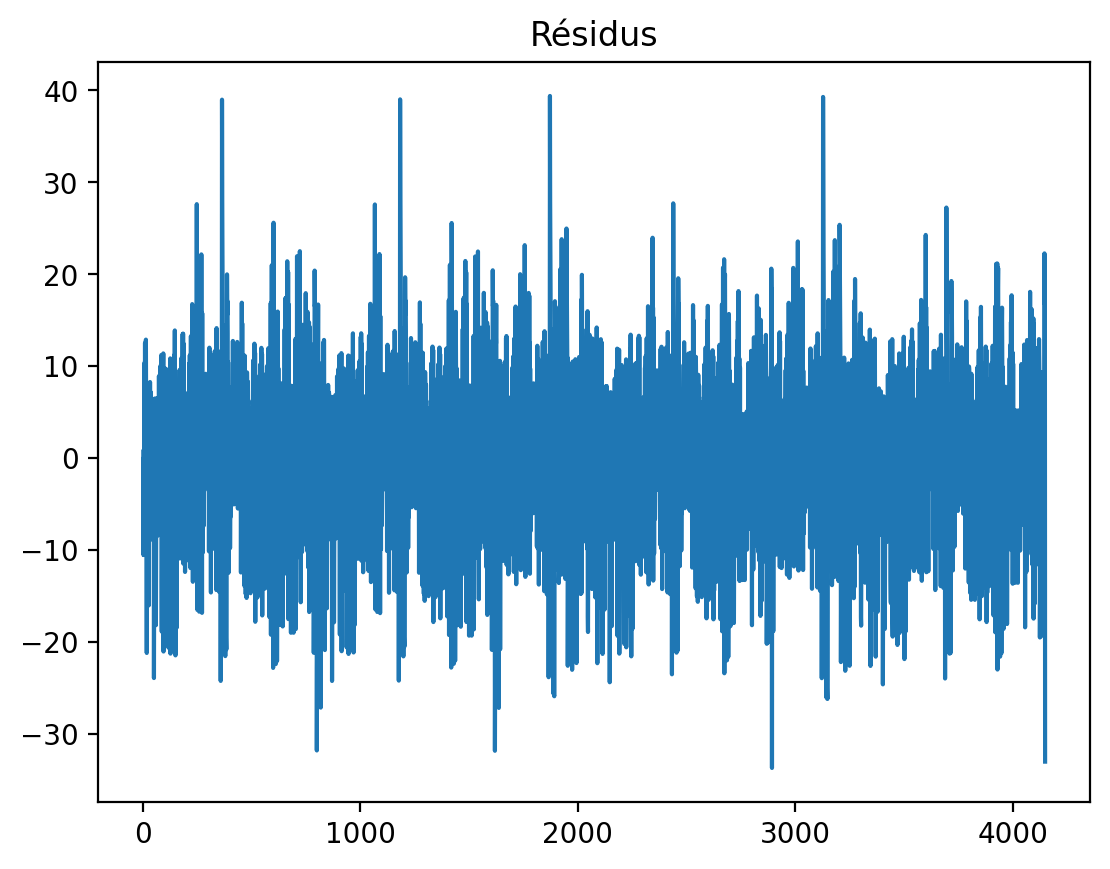

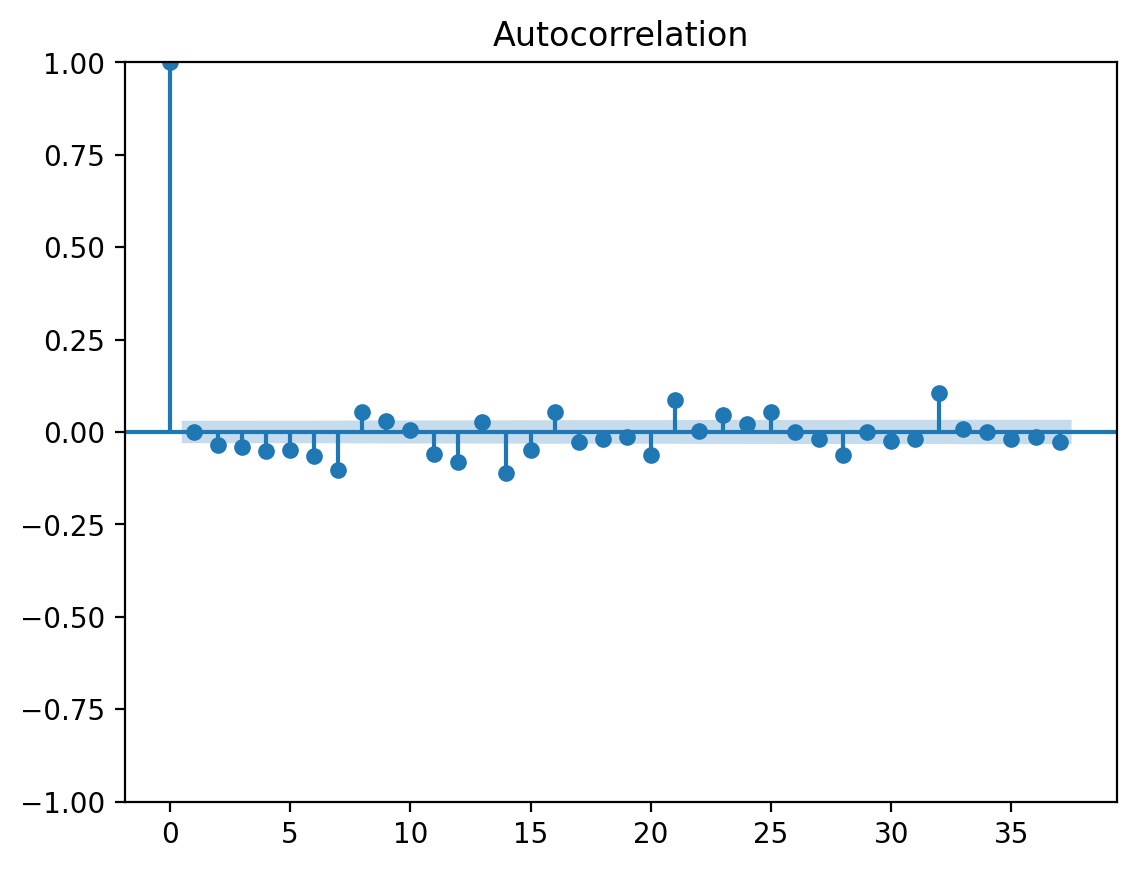

In [256]:
residus = res.resid[2:]
residus.plot(title="Résidus")
plot_acf(residus);

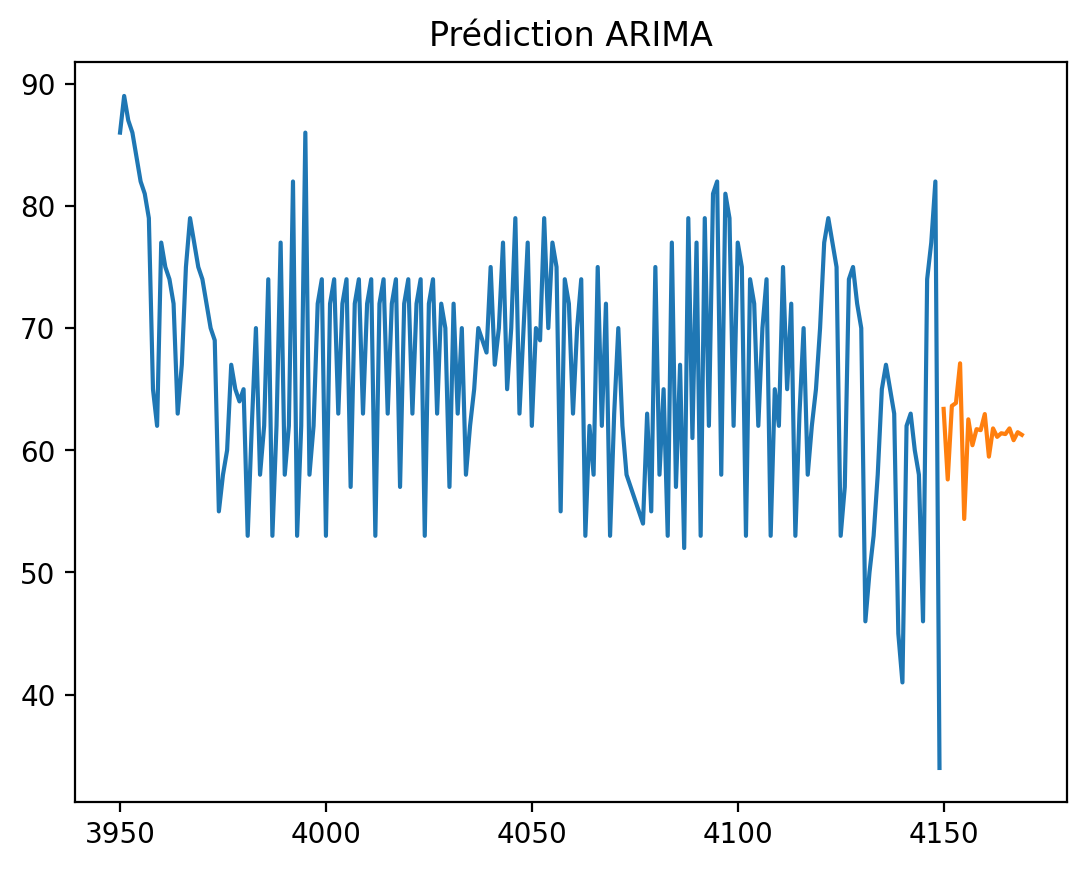

In [257]:
plt.plot(data[-200:])
plt.plot(res.forecast(20))
plt.title("Prédiction ARIMA");

La prédiction par le modèle ARIMA semble pas trop ample, les valeurs prédites sont trop écartées et ne décrivent pas le rythme instaurée par le morceau. Il n'y a pas de metrics pour indiquer le taux d'erreurs, mais à l'oeil nu on sait que ce n'est pas suffisant.

### SARIMAX

On essaye maintenant le modèle SARIMAX, un modèle qui cette fois tient compte des saisonnalités.

In [226]:
from statsmodels.tsa.statespace.sarimax import  SARIMAX

train = data[:-20]
test = data[-20:]

mod = SARIMAX(train, order=(5,1,0), simple_differencing=False,
              enforce_stationarity=False) #seasonal_order=(3,1,0,12)

res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               note_int   No. Observations:                 4130
Model:               SARIMAX(5, 1, 0)   Log Likelihood              -14932.543
Date:                Tue, 07 Nov 2023   AIC                          29877.085
Time:                        10:48:59   BIC                          29915.033
Sample:                             0   HQIC                         29890.516
                               - 4130                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8425      0.013    -66.081      0.000      -0.867      -0.818
ar.L2         -0.6493      0.015    -42.441      0.000      -0.679      -0.619
ar.L3         -0.4712      0.017    -27.676      0.000      -0.505      -0.438
ar.L4         -0.3537      0.016    -22.209      0.000      -0.385      -0.323
ar.L5         -0.3131      0.013    -23.794      0.000      -0.339      -0.287
sigma2        81.7691      1.684     48.556      0.000      78.468      85.070
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.11
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.08
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

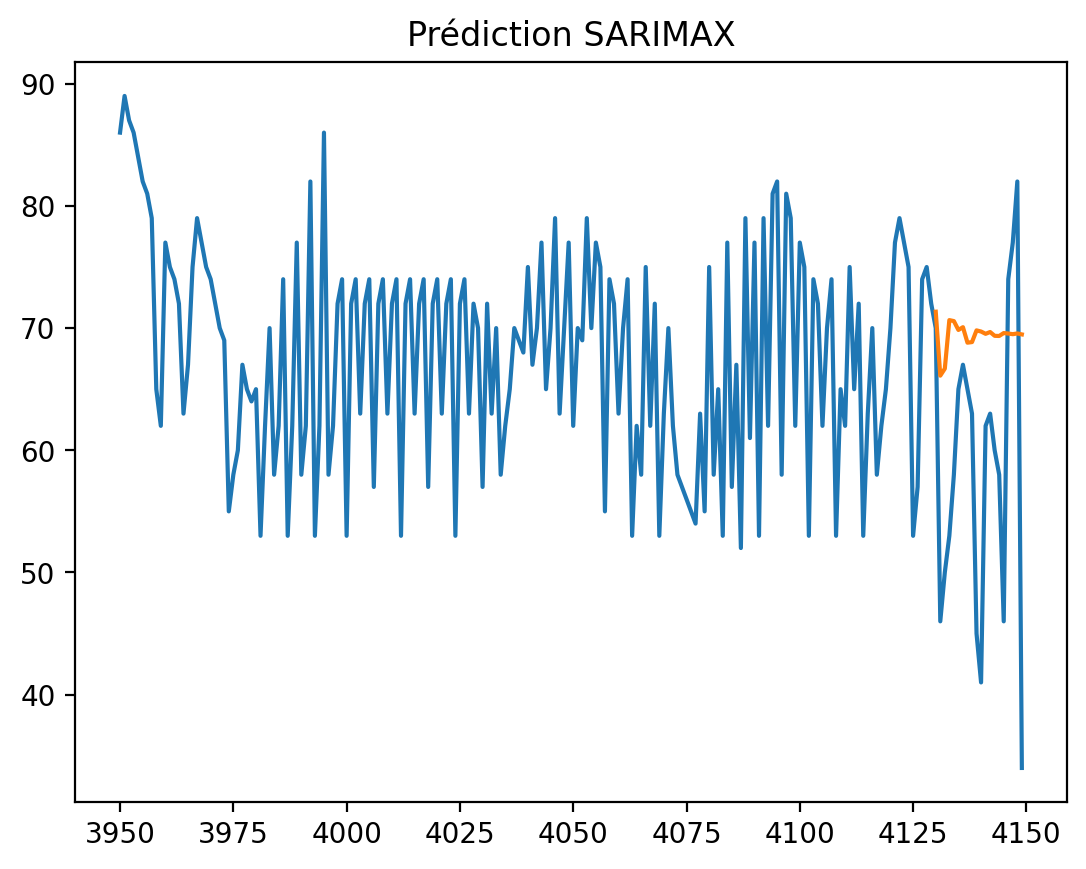

In [229]:
plt.plot(data[-200:])
plt.plot(res.forecast(20))
plt.title("Prédiction SARIMAX");

Cette fois ci, en utilisant un modèle tenant compte des saisonnalités et en superposant les prédictions avec le snotes réelles on peut voir que les prédictions ne sont pas du tout en phase avec les notes réelles.

### Auto ARIMA

Voyant les résultats de modèles ARIMA et SARIMAX, on ne va pas essayer un modèle intégrant les données exogènes au vu des résultats. A la place, nous allon essayer un modèle auto ARIMA qui permettrait de déterminer les meilleurs ordres du modèle. En effet, les ordres sont ce qu'il y a de plus durs à déterminer sur un tel modèle avec des données pareilles où l'erreur résulterait de l'interprétation.

In [230]:
data_auto_arima = df_music[['note_int']]
data_auto_arima

,note_int
0,70
1,58
2,65
3,53
4,62
...,...
4145,46
4146,74
4147,77
4148,82


In [127]:
!pip install pmdarima --user;


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --user;


In [128]:
from pmdarima.arima import auto_arima

In [129]:
stepwise_model = auto_arima(data_auto_arima, start_p=0, start_q=0,
                           max_p=1, max_q=1, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

Performing stepwise search to minimize aic


KeyboardInterrupt: 

In [133]:
stepwise_model.aic()

19926.555728297797

In [134]:
stepwise_model.seasonal_order

(2, 1, 0, 12)

Maintenant en possession du théorique modèle le plus adapté, avec les meilleurs ordres, on peut essayer d'effectuer les mêmes prédictions que celle du début.

In [135]:
train = data_auto_arima[:-20]
test = data_auto_arima[-20:]

In [136]:
stepwise_model.fit(train)

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [137]:
future_forecast, ci = stepwise_model.predict(n_periods=20, return_conf_int=True,alpha=0.05)

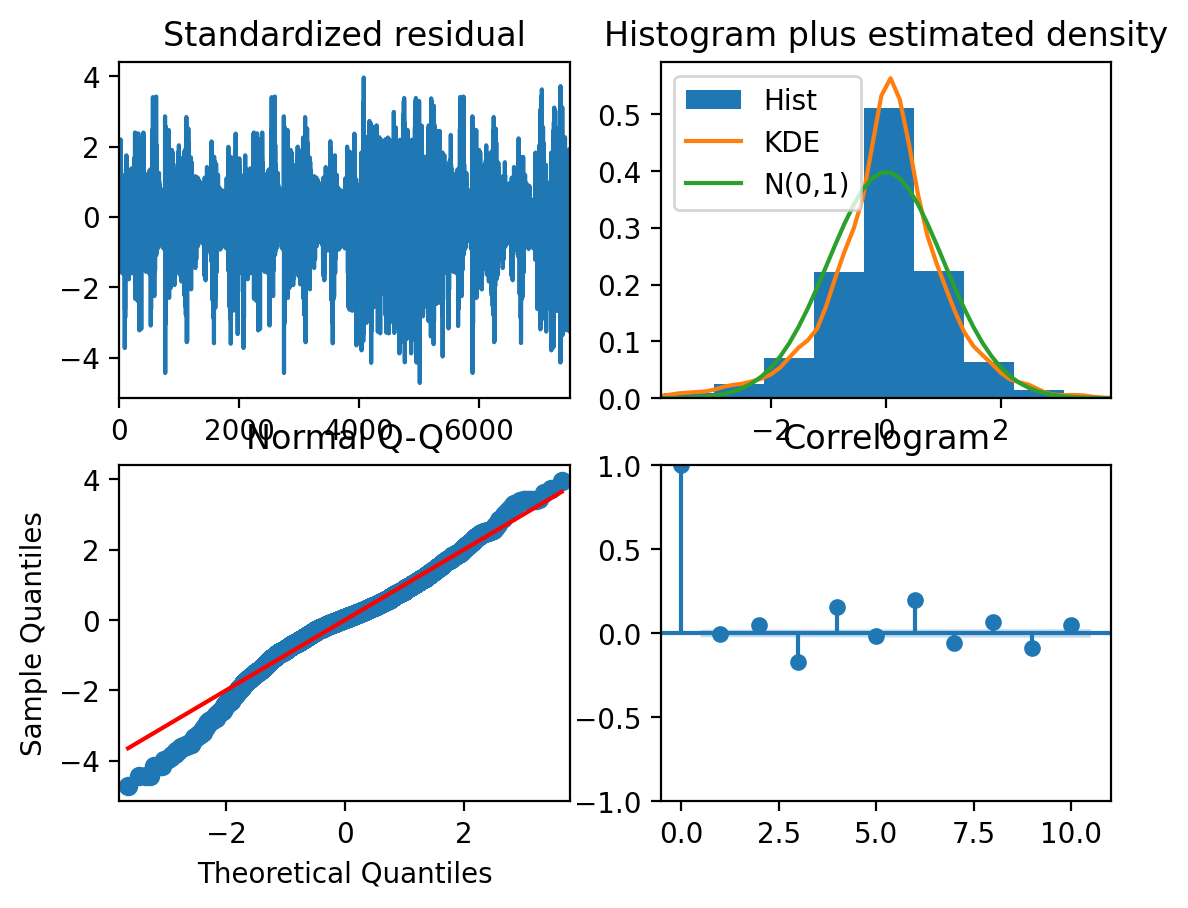

In [138]:
stepwise_model.plot_diagnostics();

In [139]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])

In [140]:
future_forecast_ci = pd.DataFrame(ci, index=test.index, columns = ['lwb', 'ub'])

<Axes: >

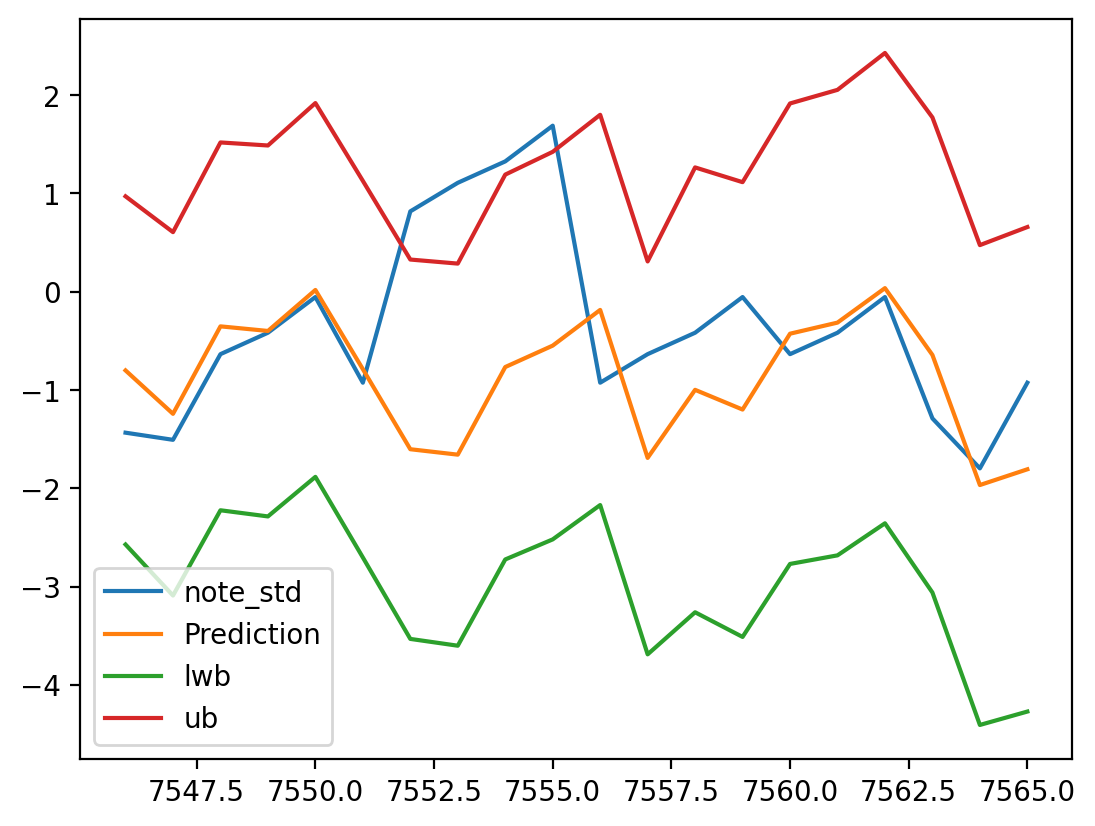

In [141]:
pd.concat([test,future_forecast, future_forecast_ci],axis=1).plot()

In [142]:
future_forecast2 = future_forecast

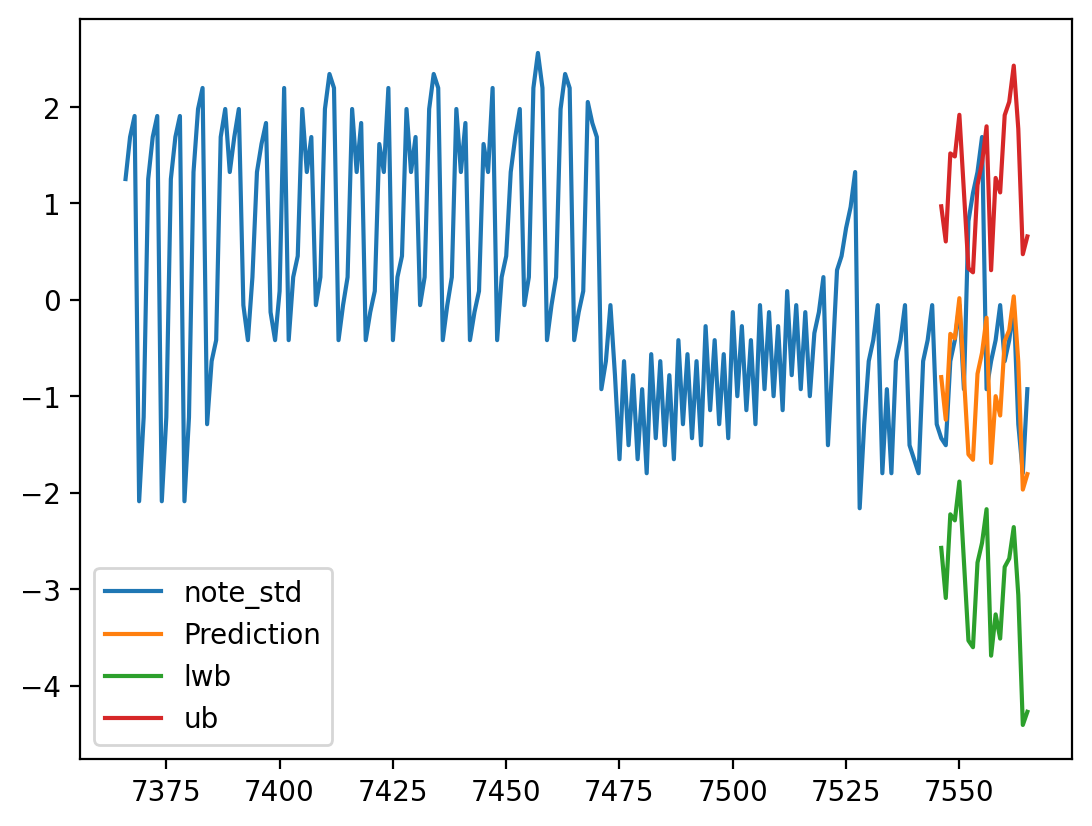

In [144]:
out = pd.concat([data[-200:],future_forecast2,future_forecast_ci],axis=1).plot(
    #colormap=('blue', 'green', 'gray', 'gray'),
    legend = "bottom_right",)

Ce qui peut sembler différent, ce que lorsque effectué par nous même l'ARIMA donnait des résultats plutôt moyen, mais en cherchant les meilleurs ordres possibles, on peut voir que la prédiction (en orange) est très cohérente par rapport aux notes réelles.

In [148]:
smape_loss(test, future_forecast2)

1.9695471469539438

En ayant la loss, on peut voir que la loss est plutôt basse rivalisant même avec le meilleurs modèles que l'on avait : une forêt aléatoire.